In [26]:
import pandas as pd
import numpy as np
import pickle
from keras.models import load_model
from keras.utils import Sequence

In [6]:
cd ..

E:\Dropbox\Projektit\Sähköbussit\TripPredictor_3


In [8]:
ls

 Volume in drive E is Storage
 Volume Serial Number is EC63-9DAD

 Directory of E:\Dropbox\Projektit\S„hk”bussit\TripPredictor_3

02.10.2018  09:49    <DIR>          .
02.10.2018  09:49    <DIR>          ..
02.10.2018  10:36    <DIR>          .git
19.09.2018  16:46                80 .gitignore
02.10.2018  10:36    <DIR>          .idea
19.09.2018  19:09    <DIR>          .ipynb_checkpoints
01.10.2018  22:58    <DIR>          __pycache__
01.10.2018  23:42                 0 01-10-2018__23_42_00.log
02.10.2018  00:13                 0 02-10-2018__00_13_03.log
02.10.2018  00:14                 0 02-10-2018__00_14_30.log
02.10.2018  00:16                 0 02-10-2018__00_16_03.log
02.10.2018  00:17                 0 02-10-2018__00_17_34.log
02.10.2018  00:27                 0 02-10-2018__00_27_29.log
02.10.2018  10:34        13ÿ591ÿ544 02-10-2018__09_43_02.h5
02.10.2018  10:34               371 02-10-2018__09_43_02.log
01.10.2018  23:03    <DIR>          data
14.09.2018  13:35               

In [9]:
train_log = pd.read_csv('02-10-2018__09_43_02.log')

In [13]:
train_log

,epoch,loss,val_loss
0,0,0.320341,0.229842
1,1,0.218281,0.196286
2,2,0.195839,0.293564
3,3,0.188718,0.166474
4,4,0.168894,0.179509
5,5,0.148482,0.122336
6,6,0.122299,0.115397
7,7,0.115880,0.105264


In [14]:
model = load_model('02-10-2018__09_43_02.h5')

In [15]:
X_train, X_test, y_train, y_test = pickle.load(open('./data/trips_fullscale_dataset.pickle', 'rb'))

In [16]:
len(X_test)

5076

In [71]:
class SequenceBatchGenerator(Sequence):
    """
        A generator class to produce a single batch of sequences
        for LSTM training

        Arguments:
            x_set: The whole training set, python list of length m_examples.
            A single example can be accessed in the manner x_set[example_idx]
            and is a numpy array of shape (1, timesteps, n_features). Timesteps
            can vary between examples.

            y_set: The labels corresponding to elements in x_set

            batch_size: The batch size to be used in training

        Outputs:
            batch_x_tensor: Numpy array of shape (batch_size, max_timesteps_batch,
            n_input_features)
            batch_y_tensor: Numpy array of shape (batch_size, max_timesteps_batch,
            n_output_features)


        #https://keras.io/utils/#sequence


    """

    def __init__(self, x_set, y_set, batch_size=128):
        """
        """
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size

        # Make sure n_features is same for all examples
        unique_input_dims = len(set([example.shape[2] for example in x_set]))
        unique_output_dims = len(set([example.shape[2] for example in y_set]))
        if not unique_input_dims == unique_output_dims == 1:
            raise Exception("n_features needs to be same for all examples")

        self.input_dim = x_set[0].shape[2]
        self.output_dim = y_set[0].shape[2]


    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size].copy()
        batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size].copy()

        # get all the stuff required for reshaping
        max_timesteps_batch = max([seq.shape[1] for seq in batch_x])

        # initialize return variables as 3D tensors
        batch_x_tensor = np.zeros((len(batch_x), max_timesteps_batch, self.input_dim))
        batch_y_tensor = np.zeros((len(batch_y), max_timesteps_batch, self.output_dim))

        # Zero pad all samples within batch to max length
        for i in range(len(batch_x)):
            padding_dims = ((0, 0), (0, max_timesteps_batch - batch_x[i].shape[1]), (0, 0))
            batch_x[i] = np.pad(batch_x[i], padding_dims, 'constant', constant_values=(None, 0))
            batch_y[i] = np.pad(batch_y[i], padding_dims, 'constant', constant_values=(None, 0))

            # Reshape to meet Keras expectation
            batch_x[i][0] = np.reshape(batch_x[i].transpose(), (1, max_timesteps_batch, self.input_dim))
            batch_y[i][0] = np.reshape(batch_y[i].transpose(), (1, max_timesteps_batch, self.output_dim))

            # Append x, y to returnable tensor
            batch_x_tensor[i, :, :] = batch_x[i]
            batch_y_tensor[i, :, :] = batch_y[i]

        return batch_x_tensor, batch_y_tensor


In [72]:
batch_test_gen = SequenceBatchGenerator(X_test, y_test, batch_size = 1)

In [49]:
preds = []
for i in range(len(batch_test_gen)):
    batch_x_tensor = batch_test_gen.__getitem__(i)
    preds.append(model.predict_on_batch(batch_x_tensor))

In [50]:
len(preds)

5076

In [51]:
preds[0].shape

(1, 206, 1)

In [52]:
preds[1].shape

(1, 100, 1)

In [53]:
preds[2].shape

(1, 199, 1)

In [54]:
y_test[0].shape

(1, 206, 1)

In [55]:
y_test[1].shape

(1, 100, 1)

In [56]:
len(y_test)

5076

In [63]:
pickle.dump(preds, open('preds_dump.pickle', 'wb'))

In [64]:
ls

 Volume in drive E is Storage
 Volume Serial Number is EC63-9DAD

 Directory of E:\Dropbox\Projektit\S„hk”bussit\TripPredictor_3

02.10.2018  11:36    <DIR>          .
02.10.2018  11:36    <DIR>          ..
02.10.2018  10:45    <DIR>          .git
19.09.2018  16:46                80 .gitignore
02.10.2018  10:45    <DIR>          .idea
19.09.2018  19:09    <DIR>          .ipynb_checkpoints
01.10.2018  22:58    <DIR>          __pycache__
01.10.2018  23:42                 0 01-10-2018__23_42_00.log
02.10.2018  00:13                 0 02-10-2018__00_13_03.log
02.10.2018  00:14                 0 02-10-2018__00_14_30.log
02.10.2018  00:16                 0 02-10-2018__00_16_03.log
02.10.2018  00:17                 0 02-10-2018__00_17_34.log
02.10.2018  00:27                 0 02-10-2018__00_27_29.log
02.10.2018  10:34        13ÿ591ÿ544 02-10-2018__09_43_02.h5
02.10.2018  10:34               371 02-10-2018__09_43_02.log
01.10.2018  23:03    <DIR>          data
14.09.2018  13:35               

In [66]:
maes = []
for pred, ground_truth in zip(preds, y_test):
    error = np.mean(np.abs(pred - ground_truth))
    maes.append(error)

In [67]:
len(maes)

5076

In [68]:
mae = np.mean(maes)

In [69]:
mae

0.20317749217645606

In [76]:
tgen = SequenceBatchGenerator(X_test, y_test, batch_size = 256)

In [77]:
model.evaluate_generator(tgen)

0.10214438296449381

In [78]:
model.evaluate_generator(tgen)

0.10214438296449381

In [79]:
tgen = SequenceBatchGenerator(X_test, y_test, batch_size = 128)

In [80]:
model.evaluate_generator(tgen)

0.10526444092451634

In [81]:
model.evaluate_generator(tgen)

0.10526444092451634

In [82]:
tgen = SequenceBatchGenerator(X_test, y_test, batch_size = 1)

In [83]:
model.evaluate_generator(tgen)

0.203177491900892

Issue : Using a larger batch size results in overly optimistic MAE in evaluation, because of the additional zero padding in batches

In [87]:
lengths_X =[ex.shape[1] for ex in X_train]

In [88]:
lengths_X

[118,
 101,
 172,
 255,
 195,
 144,
 195,
 197,
 220,
 195,
 87,
 190,
 86,
 134,
 164,
 119,
 212,
 111,
 212,
 123,
 96,
 214,
 128,
 192,
 114,
 177,
 212,
 200,
 98,
 125,
 253,
 177,
 202,
 98,
 116,
 121,
 125,
 112,
 122,
 213,
 87,
 84,
 128,
 217,
 195,
 201,
 94,
 197,
 191,
 107,
 111,
 200,
 111,
 117,
 113,
 208,
 193,
 99,
 211,
 84,
 222,
 201,
 104,
 164,
 186,
 178,
 195,
 100,
 123,
 105,
 203,
 105,
 116,
 206,
 130,
 116,
 132,
 171,
 116,
 121,
 189,
 104,
 222,
 166,
 173,
 122,
 96,
 169,
 103,
 110,
 168,
 97,
 174,
 198,
 178,
 98,
 112,
 118,
 114,
 192,
 232,
 201,
 197,
 201,
 184,
 202,
 166,
 91,
 125,
 131,
 117,
 197,
 179,
 96,
 177,
 208,
 113,
 232,
 200,
 97,
 100,
 197,
 181,
 191,
 117,
 168,
 175,
 225,
 89,
 200,
 206,
 116,
 188,
 199,
 206,
 87,
 112,
 198,
 123,
 192,
 126,
 124,
 116,
 200,
 122,
 189,
 195,
 80,
 176,
 193,
 186,
 188,
 196,
 95,
 203,
 121,
 99,
 102,
 205,
 178,
 198,
 89,
 210,
 189,
 109,
 115,
 191,
 188,
 189,
 90,
 19

In [90]:
import matplotlib.pyplot as plt
%matplotlib inline

(array([3.000e+00, 2.000e+01, 3.070e+02, 1.366e+03, 2.689e+03, 2.539e+03,
        9.790e+02, 2.860e+02, 2.820e+02, 8.560e+02, 1.868e+03, 2.778e+03,
        2.072e+03, 9.910e+02, 3.830e+02, 1.630e+02, 6.700e+01, 1.800e+01,
        1.000e+01, 2.000e+00]),
 array([ 45.  ,  58.05,  71.1 ,  84.15,  97.2 , 110.25, 123.3 , 136.35,
        149.4 , 162.45, 175.5 , 188.55, 201.6 , 214.65, 227.7 , 240.75,
        253.8 , 266.85, 279.9 , 292.95, 306.  ]),
 <a list of 20 Patch objects>)

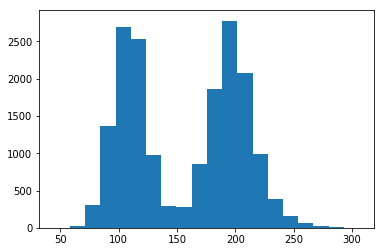

In [92]:
plt.hist(lenghts_X, bins=20)

In [93]:
lengths_test =[ex.shape[1] for ex in X_test]

(array([  3.,  35., 206., 509., 724., 561., 235.,  78.,  47., 133., 287.,
        561., 681., 509., 270., 124.,  61.,  33.,  13.,   6.]),
 array([ 59.,  70.,  81.,  92., 103., 114., 125., 136., 147., 158., 169.,
        180., 191., 202., 213., 224., 235., 246., 257., 268., 279.]),
 <a list of 20 Patch objects>)

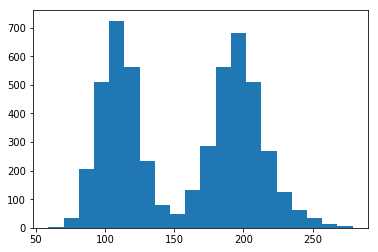

In [95]:
plt.hist(lengths_test, bins=20)